# K-Nearest Neigbor Regression (KNN)

Predict the bike demand in the next hour based on previously evaluated features

In [1]:
import pandas as pd
import numpy as np
import re
import datetime as dt #for working with times objects

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
import warnings
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsRegressor

import dataframe with features

In [2]:
df_boston_weather = pd.read_pickle("df_boston.pkl")
df_boston_weather = df_boston_weather.drop("start_time", axis=1)
df_boston_weather = df_boston_weather.drop("spring", axis=1)
df_boston_weather = df_boston_weather.drop("summer", axis=1)
df_boston_weather = df_boston_weather.drop("autumn", axis=1)
df_boston_weather = df_boston_weather.drop("winter", axis=1)
df_boston_weather = df_boston_weather.drop("hour", axis=1)
df_boston_weather

,count,mean_temp,precip,rushhour,weekday,season
6,0,-5.6,0,0,1,4
7,0,-5.6,0,1,1,4
8,4,-5.6,0,1,1,4
9,2,-4.4,0,1,1,4
10,8,-5.6,0,0,1,4
...,...,...,...,...,...,...
8755,26,11.7,0,0,1,4
8756,10,11.1,0,0,1,4
8757,22,10.6,0,0,1,4
8758,18,10.0,0,0,1,4


Define X (features) and y (target value) - vector

In [3]:
X = df_boston_weather.drop("count", axis=1)
y = df_boston_weather["count"]

## KNN-Regression: 1-Dimensional (`mean_temp`)

Do a KNN-Regression just based on one feature, to see how well the model performs

Split dataset in train and test set

In [4]:
x_train, x_test, y_train, y_test = train_test_split(X["mean_temp"], y, test_size=0.3,random_state=10)

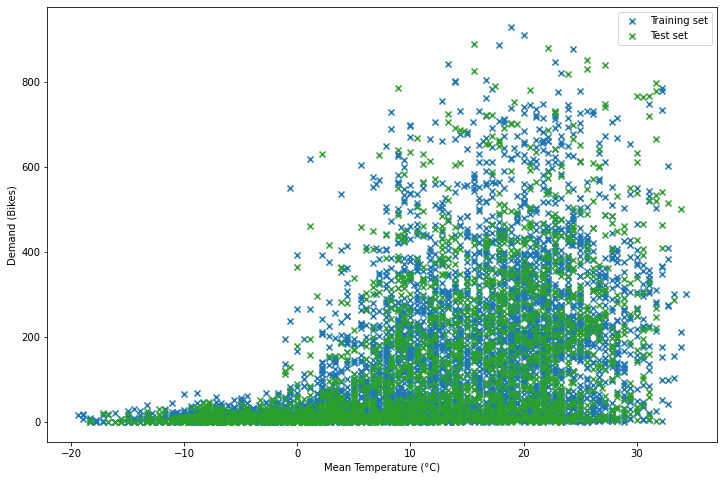

In [5]:
plt.figure(figsize = (12,8))
plt.scatter(x_train, y_train, marker='x', color="C0")
plt.scatter(x_test, y_test, marker='x', color="C2")
plt.xlabel("Mean Temperature (°C)")
plt.ylabel("Demand (Bikes)")
plt.legend(['Training set', 'Test set'])
plt.show()

do KNN-regression (initially with k=10)

In [6]:
KNN_reg = KNeighborsRegressor(n_neighbors=10)
KNN_model = KNN_reg.fit(x_train.values.reshape((-1,1)), y_train) 

# Predict
y_hat_KNN = KNN_model.predict(x_test.values.reshape((-1,1)))

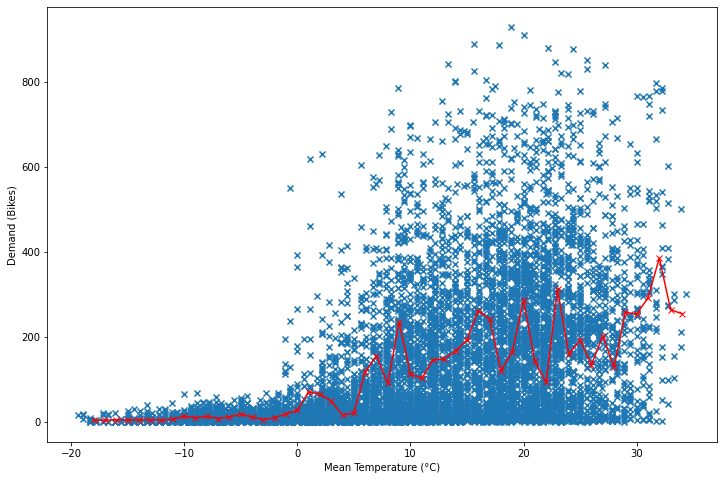

In [7]:
plt.figure(figsize = (12,8))
plt.scatter(X["mean_temp"], y, marker='x', color="C0")
plt.plot(np.arange(-18,35,1), KNN_model.predict(np.arange(-18,35,1).reshape((-1,1))), marker="x", color='r')
plt.xlabel("Mean Temperature (°C)")
plt.ylabel("Demand (Bikes)")
plt.show()

find optimal k

In [8]:
def find_knn (x_train, x_test, y_train, y_test,max_k):
    
    err_train = [] 
    err_test = []

    for n in np.arange(1,max_k):

        # fit model
        KNN_reg = KNeighborsRegressor(n_neighbors=n)
        KNN_model = KNN_reg.fit(x_train.reshape((-1,1)), y_train)


        # compute errors
        err_train.append(mean_absolute_error(KNN_model.predict(x_train.reshape((-1,1))), y_train))
        err_test.append(mean_absolute_error(KNN_model.predict(x_test.reshape((-1,1))), y_test))
        
    plt.figure(figsize = (8,6))
    plt.plot(np.arange(1,max_k), err_train,np.arange(1,max_k), err_test)
    plt.legend(["Training", "Validation"])
    plt.xlabel("Number of neighbors")
    plt.ylabel("MAE")
    #plt.ylim((0,1))
    plt.show()

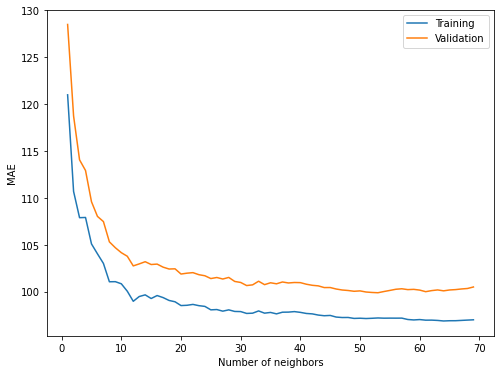

In [9]:
find_knn(x_train.values, x_test.values, y_train.values, y_test.values, 70)

looks like the optimal k is around 54, so we change it in our regression:

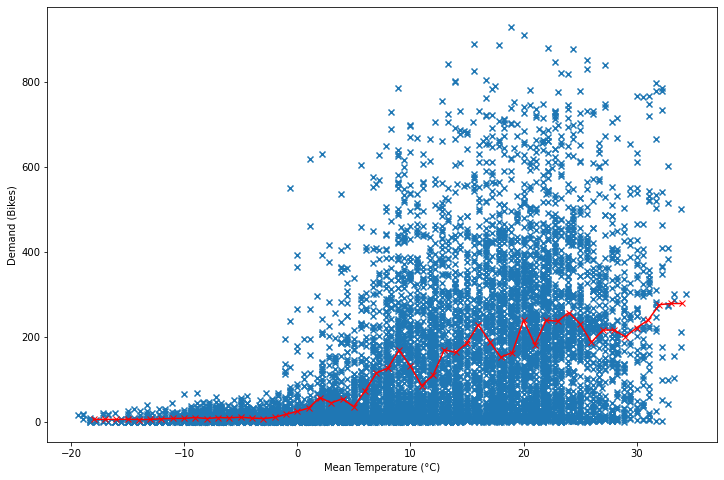

In [10]:
KNN_reg = KNeighborsRegressor(n_neighbors=54)
KNN_model = KNN_reg.fit(x_train.values.reshape((-1,1)), y_train) 

# Predict
y_hat_KNN = KNN_model.predict(x_test.values.reshape((-1,1)))

plt.figure(figsize = (12,8))
plt.scatter(X["mean_temp"], y, marker='x', color="C0")
plt.plot(np.arange(-18,35,1), KNN_model.predict(np.arange(-18,35,1).reshape((-1,1))), marker="x", color='r')
plt.xlabel("Mean Temperature (°C)")
plt.ylabel("Demand (Bikes)")
plt.show()

Evaluate the test set performance:

In [11]:
print("Test set performance:")

print("MAE:",mean_absolute_error(y_hat_KNN, y_test), "Bikes")
print("RMSE:",(mean_squared_error(y_hat_KNN, y_test))**(0.5), "Bikes")  
print("R2:",KNN_reg.score(x_test.values.reshape((-1,1)), y_test.values.reshape((-1,1))))

Test set performance:
MAE: 100.00068138457345 Bikes
RMSE: 146.41242461076266 Bikes
R2: 0.22633416465441325


-> the regression is not perfect, MAE is quite high

## KNN-Regression: 3-Dimensional (`mean_temp`, `season`, `rushhour`)

Add additional features to improve our model and have a look at the errors

split dataset in train and test set

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X[["mean_temp", "season", "rushhour"]], y, test_size=0.3,random_state=10)

Plot the demand in each season, differentiate between rushhour or no rushhour

<Figure size 1152x576 with 0 Axes>

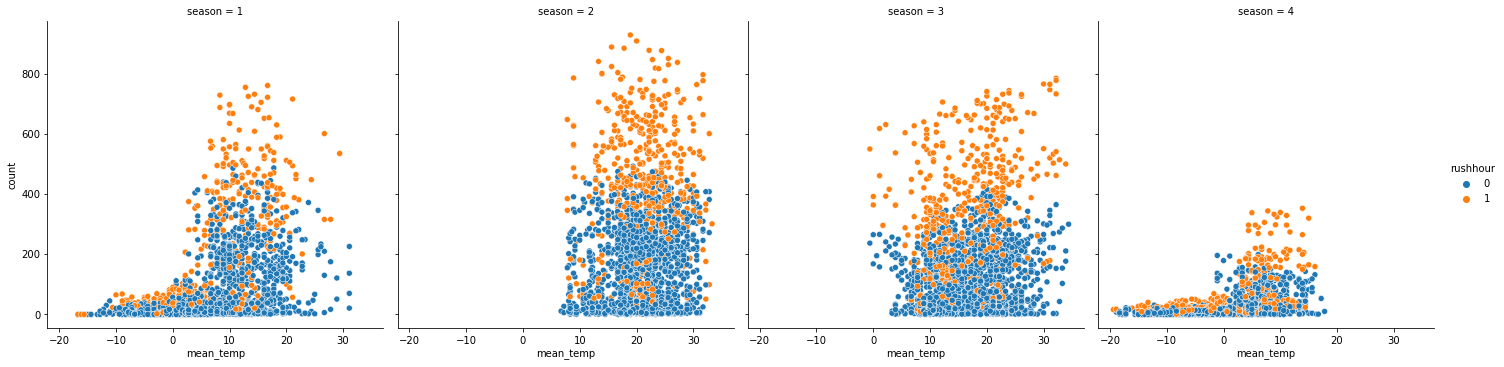

In [13]:
# Show Demand per hour with rushhour yes/no being highlighted 
# Its visible that rushhours tend to have a higher demand in every season
# The demand difference between rushhours and no-rush-hours is in summer and autumn quite big and in winter not so big
plt.figure(figsize=(16,8))
sns.relplot(x=X["mean_temp"], y=y, hue=X["rushhour"],
            col=X["season"])
plt.show()

Goal: knn regression with  features mean_temp,  season, and rushhour.
Since we choose to use mean_temp as our primary regression feature and the demand as our "target" value,
we need to split the data into different dataframes according to the features season and rushhour.

In [14]:
xp_all = df_boston_weather["mean_temp"].values
yp_all = df_boston_weather["count"].values

# Spring and rushhour
xp_spring_wd = df_boston_weather[(df_boston_weather["season"]==1) & (df_boston_weather["rushhour"]==1)]
xp_spring_wd = xp_spring_wd["mean_temp"].values
yp_spring_wd = df_boston_weather[(df_boston_weather["season"]==1) & (df_boston_weather["rushhour"]==1)]
yp_spring_wd = yp_spring_wd["count"].values

# Spring and no rushhour
xp_spring_we = df_boston_weather[(df_boston_weather["season"]==1) & (df_boston_weather["rushhour"]==0)]
xp_spring_we = xp_spring_we["mean_temp"].values
yp_spring_we = df_boston_weather[(df_boston_weather["season"]==1) & (df_boston_weather["rushhour"]==0)]
yp_spring_we = yp_spring_we["count"].values

# Summer and rushhour
xp_summer_wd = df_boston_weather[(df_boston_weather["season"]==2) & (df_boston_weather["rushhour"]==1)]
xp_summer_wd = xp_summer_wd["mean_temp"].values
yp_summer_wd = df_boston_weather[(df_boston_weather["season"]==2) & (df_boston_weather["rushhour"]==1)]
yp_summer_wd = yp_summer_wd["count"].values

# Summer and no rushhour
xp_summer_we = df_boston_weather[(df_boston_weather["season"]==2) & (df_boston_weather["rushhour"]==0)]
xp_summer_we = xp_summer_we["mean_temp"].values
yp_summer_we = df_boston_weather[(df_boston_weather["season"]==2) & (df_boston_weather["rushhour"]==0)]
yp_summer_we = yp_summer_we["count"].values

# Autumn and rushhour
xp_autumn_wd = df_boston_weather[(df_boston_weather["season"]==3) & (df_boston_weather["rushhour"]==1)]
xp_autumn_wd = xp_autumn_wd["mean_temp"].values
yp_autumn_wd = df_boston_weather[(df_boston_weather["season"]==3) & (df_boston_weather["rushhour"]==1)]
yp_autumn_wd = yp_autumn_wd["count"].values

# Autumn and no rushhour
xp_autumn_we = df_boston_weather[(df_boston_weather["season"]==3) & (df_boston_weather["rushhour"]==0)]
xp_autumn_we = xp_autumn_we["mean_temp"].values
yp_autumn_we = df_boston_weather[(df_boston_weather["season"]==3) & (df_boston_weather["rushhour"]==0)]
yp_autumn_we = yp_autumn_we["count"].values

# Winter and rushhour
xp_winter_wd = df_boston_weather[(df_boston_weather["season"]==4) & (df_boston_weather["rushhour"]==1)]
xp_winter_wd = xp_winter_wd["mean_temp"].values
yp_winter_wd = df_boston_weather[(df_boston_weather["season"]==4) & (df_boston_weather["rushhour"]==1)]
yp_winter_wd = yp_winter_wd["count"].values

# Winter and no rushhour
xp_winter_we = df_boston_weather[(df_boston_weather["season"]==4) & (df_boston_weather["rushhour"]==0)]
xp_winter_we = xp_winter_we["mean_temp"].values
yp_winter_we = df_boston_weather[(df_boston_weather["season"]==4) & (df_boston_weather["rushhour"]==0)]
yp_winter_we = yp_winter_we["count"].values

In [15]:
#Method which takes mean_temp values and corresponding demand values and does a knn regression

from sklearn.neighbors import KNeighborsRegressor

def do_knn(xp, yp, n):
    
    x_train, x_test, y_train, y_test = train_test_split(xp, yp, test_size=0.3,random_state=10)
    #Fit model
    KNN_reg = KNeighborsRegressor(n_neighbors=n)
    KNN_model = KNN_reg.fit(x_train.reshape((-1,1)), y_train) 

    # Predict
    y_hat_KNN = KNN_model.predict(x_test.reshape((-1,1)))
    
    print("Test set performance:")
    print("MAE:",mean_absolute_error(y_hat_KNN, y_test), "Bikes")
    print("RMSE:",(mean_squared_error(y_hat_KNN, y_test))**(0.5), "Bikes")  
    print("R2:",KNN_reg.score(x_test.reshape((-1,1)), y_test))
    
    return KNN_reg, KNN_model, y_hat_KNN
    

In [16]:
# Method which can be used  to find an optimal k value for the knn-regression
# It splits the input sets into train and test sets
# Then it does knn regressions for k = 1, ... , max_k
# For each regression the MAE both on the train and the test sets are calculated and plotted

def find_knn (x,y,max_k):
    
    err_train = [] 
    err_test = []
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=10)

    for n in np.arange(1,max_k):

        # fit model
        KNN_reg = KNeighborsRegressor(n_neighbors=n)
        KNN_model = KNN_reg.fit(x_train.reshape((-1,1)), y_train)
        


        # compute errors
        err_train.append(mean_absolute_error(KNN_model.predict(x_train.reshape((-1,1))), y_train))
        err_test.append(mean_absolute_error(KNN_model.predict(x_test.reshape((-1,1))), y_test))
        
    plt.figure(figsize = (8,6))
    plt.plot(np.arange(1,max_k), err_train,np.arange(1,max_k), err_test)
    plt.legend(["Training", "Validation"])
    plt.xlabel("Number of neighbors")
    plt.ylabel("MAE")
    #plt.ylim((0,1))
    plt.show()

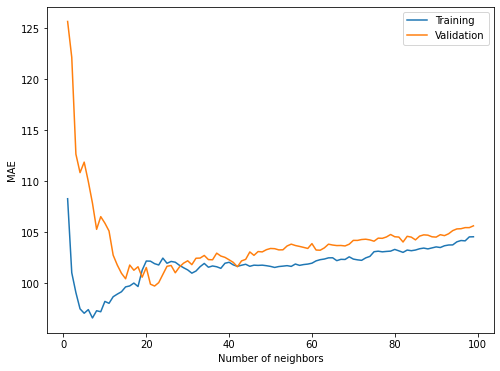

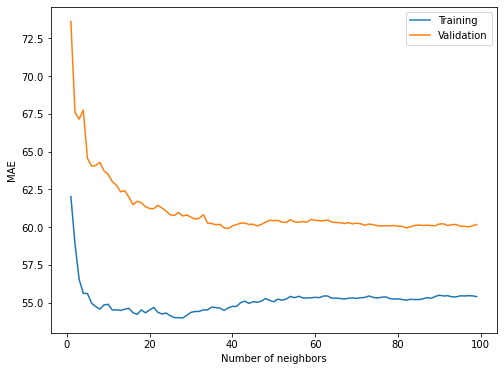

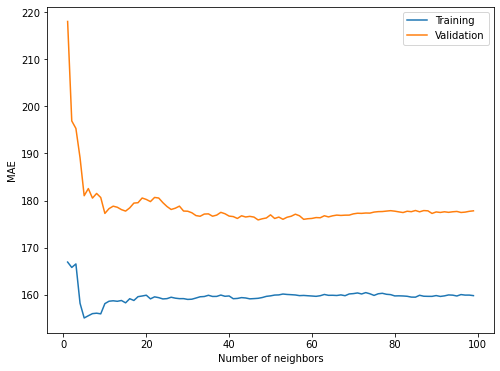

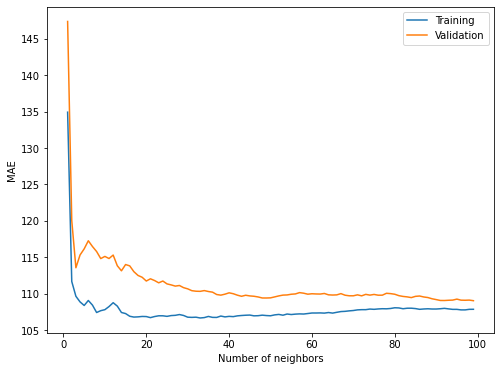

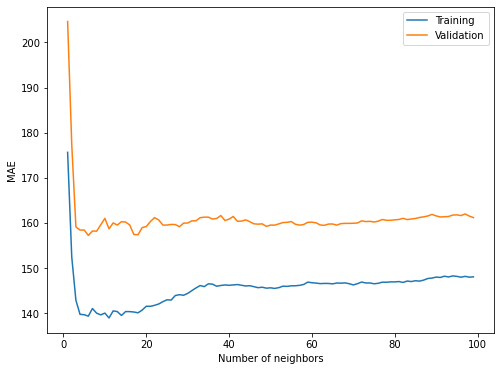

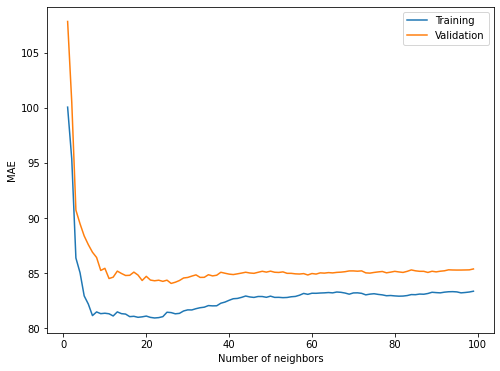

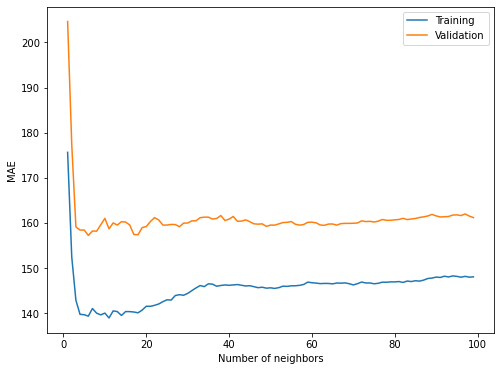

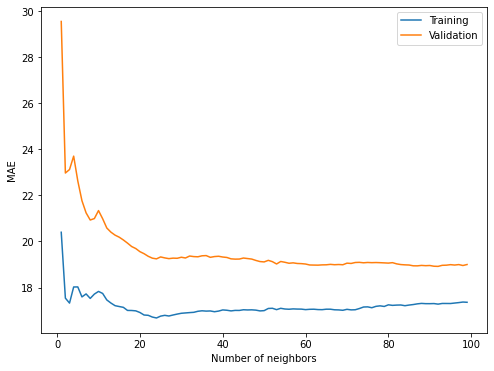

In [17]:
#Do some tests to find an optimal k
find_knn(xp_spring_wd,yp_spring_wd,100) # rushhour in spring
find_knn(xp_spring_we, yp_spring_we,100) # no russhour in spring
find_knn(xp_summer_wd,yp_summer_wd,100) # russhour in summer
find_knn(xp_summer_we, yp_summer_we,100) # no rushhour in summer
find_knn(xp_autumn_wd,yp_autumn_wd,100) # russhour in autumn
find_knn(xp_autumn_we, yp_autumn_we,100) # no rushhour in autumn
find_knn(xp_autumn_wd,yp_autumn_wd,100) # rushhour in winter
find_knn(xp_winter_we, yp_winter_we,100) # no rushhour in winter

Show knn-regressions based on season and rushhour (now with optimized k).
Create for each season one plot.
Each plot has two knn_regressions: One for the rushhours and one for the non-rushhours.



rushhour: red line
no rushhour: blue line


Spring:
rushhour
Test set performance:
MAE: 102.30636942675159 Bikes
RMSE: 142.3883897480123 Bikes
R2: 0.46765688313778875
no rushhour
Test set performance:
MAE: 60.16413793103448 Bikes
RMSE: 90.19175405289516 Bikes
R2: 0.22768876448894004


Summer:
rushhour
Test set performance:
MAE: 176.67839433293977 Bikes
RMSE: 214.73195496875954 Bikes
R2: 0.05719328308173477
no rushhour
Test set performance:
MAE: 110.13201086956524 Bikes
RMSE: 127.9366834153333 Bikes
R2: -0.03001973990286677


Autumn:
rushhour
Test set performance:
MAE: 160.8310064935065 Bikes
RMSE: 196.58489397655336 Bikes
R2: 0.03824697977661318
no rushhour
Test set performance:
MAE: 84.91702127659575 Bikes
RMSE: 98.9765598996776 Bikes
R2: 0.03145740524492591


Winter:
rushhour
Test set performance:
MAE: 28.728944060339412 Bikes
RMSE: 46.09972612981084 Bikes
R2: 0.40371723267852444
no rushhour
Test set performance:
MAE: 20.274214447683832 Bikes
RMSE: 31.76645919151809 Bikes
R2: 0.148

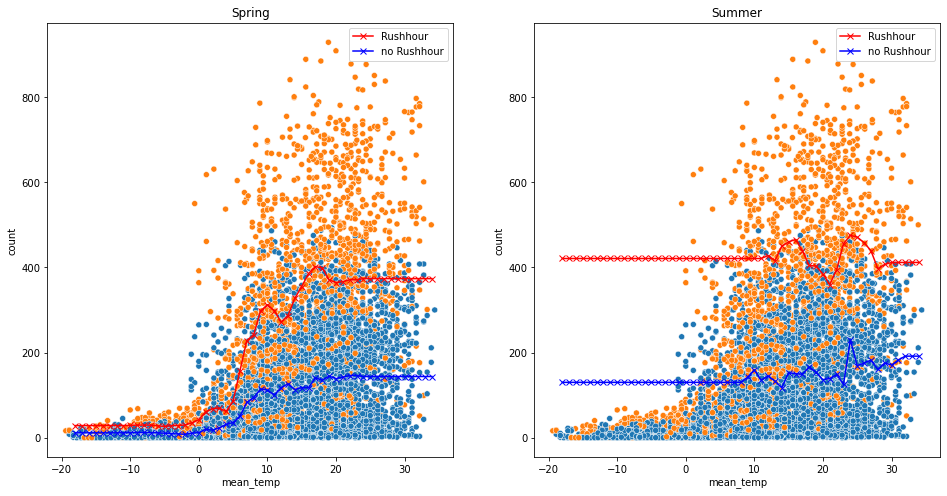

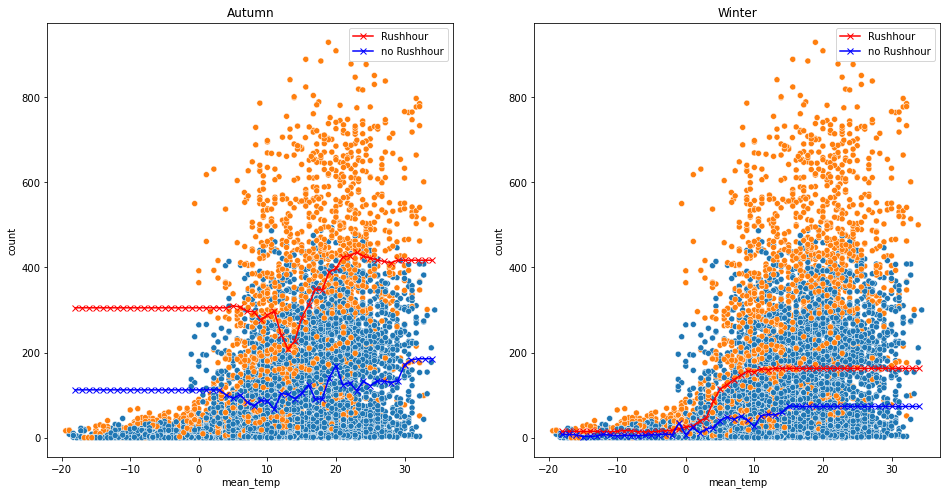

In [18]:

#Spring
print('')
print('')
print('rushhour: red line')
print('no rushhour: blue line')
print('')
print('')
print('Spring:')

print('rushhour')
spring_wd_reg, spring_wd_model, spring_wd_hat = do_knn(xp_spring_wd, yp_spring_wd, 40)
print('no rushhour')
spring_we_reg, spring_we_model, spring_we_hat = do_knn(xp_spring_we, yp_spring_we, 100)


plt.figure(figsize = (16,8))
plt.subplot(1,2,1)
plt.title("Spring")
sns.scatterplot(x=X["mean_temp"], y=y, 
                hue=X["rushhour"])
plt.plot(np.arange(-18,35,1), spring_wd_reg.predict(np.arange(-18,35,1).reshape((-1,1))), marker="x", color='r')
plt.plot(np.arange(-18,35,1), spring_we_reg.predict(np.arange(-18,35,1).reshape((-1,1))), marker="x", color='b')
plt.legend(['Rushhour', 'no Rushhour'])


#Summer
print('')
print('')
print('Summer:')
print('rushhour')
summer_wd_reg, summer_wd_model, summer_wd_hat = do_knn(xp_summer_wd, yp_summer_wd, 55)
print('no rushhour')
summer_we_reg, summer_we_model, summer_we_hat = do_knn(xp_summer_we, yp_summer_we, 40)

plt.subplot(1,2,2)
plt.title("Summer")
sns.scatterplot(x=X["mean_temp"], y=y, 
                hue=X["rushhour"])
plt.plot(np.arange(-18,35,1), summer_wd_reg.predict(np.arange(-18,35,1).reshape((-1,1))), marker="x", color='r')
plt.plot(np.arange(-18,35,1), summer_we_reg.predict(np.arange(-18,35,1).reshape((-1,1))), marker="x", color='b')
plt.legend(['Rushhour', 'no Rushhour'])


#Autumn
print('')
print('')
print('Autumn:')
print('rushhour')
autumn_wd_reg, autumn_wd_model, autumn_wd_hat = do_knn(xp_autumn_wd, yp_autumn_wd, 40)
print('no rushhour')
autumn_we_reg, autumn_we_model, autumn_we_hat = do_knn(xp_autumn_we, yp_autumn_we, 40)


plt.figure(figsize = (16,8))
plt.subplot(1,2,1)
plt.title("Autumn")
sns.scatterplot(x=X["mean_temp"], y=y, 
                hue=X["rushhour"])
plt.plot(np.arange(-18,35,1), autumn_wd_reg.predict(np.arange(-18,35,1).reshape((-1,1))), marker="x", color='r')
plt.plot(np.arange(-18,35,1), autumn_we_reg.predict(np.arange(-18,35,1).reshape((-1,1))), marker="x", color='b')
plt.legend(['Rushhour', 'no Rushhour'])


#Winter
print('')
print('')
print('Winter:')
print('rushhour')
winter_wd_reg, winter_wd_model, winter_wd_hat = do_knn(xp_winter_wd, yp_winter_wd, 43)
print('no rushhour')
winter_we_reg, winter_we_model, winter_we_hat = do_knn(xp_winter_we, yp_winter_we, 14)

plt.subplot(1,2,2)
plt.title("Winter")
sns.scatterplot(x=X["mean_temp"], y=y, 
                hue=X["rushhour"])
plt.plot(np.arange(-18,35,1), winter_wd_reg.predict(np.arange(-18,35,1).reshape((-1,1))), marker="x", color='r')
plt.plot(np.arange(-18,35,1), winter_we_reg.predict(np.arange(-18,35,1).reshape((-1,1))), marker="x", color='b')
plt.legend(['Rushhour', 'no Rushhour'])

plt.show()

In [19]:
#calculate the total R2 of the above regression:
# Since there are 8 regressions with each having their on R2 value we have to multiply them with their proportion
# of the total demand and add those products together
def sum (yp):
    y1 =0
    for x in yp:
        y1 += x
    return y1

demand_spring1 = sum(yp_spring_wd)
demand_spring2 = sum(yp_spring_we)
demand_summer1 = sum(yp_summer_wd)
demand_summer2 = sum(yp_summer_we)
demand_autumn1 = sum(yp_autumn_wd)
demand_autumn2 = sum(yp_autumn_we)
demand_winter1 = sum(yp_winter_wd)
demand_winter2 = sum(yp_winter_we)

# calculate the total R2:
demand_total = demand_spring1 + demand_spring2 + demand_summer1 + demand_summer2 + demand_autumn1 + demand_autumn2 + demand_winter1 + demand_winter2
R2 = (0.37438743361384075*demand_spring1 + 0.2174071576995642*demand_spring2+0.1630755929263451*demand_summer1 +  -0.006079429246799162* demand_summer2 +0.10828252401488603*demand_autumn1 + 0.025843568608425627*demand_autumn2 +0.39362543343737355*demand_winter1  + 0.19769788006495104*demand_winter2) /demand_total
print(R2)

0.1260248866701981


# KNN-Regression: Full feature set

Last but not least we will do an regression on the full feature set, including `mean_temp`, `precip`, `rushhour`, `season` and `Weekday`

In [20]:
features = list(zip(X["mean_temp"], X["rushhour"], X["season"], X["weekday"], X["precip"]))

In [21]:
features_s = pd.Series(features)

split data into train and test set

In [22]:
x_train, x_test, y_train, y_test = train_test_split(features, y, test_size=0.3,random_state=10)

create the KNN-model (initially with k=10) and print test set performance

In [23]:
# Fit model
KNN_reg = KNeighborsRegressor(n_neighbors=10)
KNN_model = KNN_reg.fit(x_train, y_train.values) 

# Predict
y_hat_KNN = KNN_model.predict(x_test)

In [24]:
print("Test set performance:")

print("MAE:",mean_absolute_error(y_hat_KNN, y_test), "Bikes")
print("RMSE:",(mean_squared_error(y_hat_KNN, y_test))**(0.5), "Bikes")  
print("R2:",KNN_reg.score(x_test, y_test))

Test set performance:
MAE: 77.85923957481602 Bikes
RMSE: 111.28255770435555 Bikes
R2: 0.553057399604165


find optimal k

In [25]:
def find_knn (x_train, x_test, y_train, y_test,max_k):
    
    err_train = [] 
    err_test = []

    for n in np.arange(1,max_k):

        # fit model
        KNN_reg = KNeighborsRegressor(n_neighbors=n)
        KNN_model = KNN_reg.fit(x_train, y_train)


        # compute errors
        err_train.append(mean_absolute_error(KNN_model.predict(x_train), y_train))
        err_test.append(mean_absolute_error(KNN_model.predict(x_test), y_test))
        
    plt.figure(figsize = (8,6))
    plt.plot(np.arange(1,max_k), err_train,np.arange(1,max_k), err_test)
    plt.legend(["Training", "Validation"])
    plt.xlabel("Number of neighbors")
    plt.ylabel("MAE")
    #plt.ylim((0,1))
    plt.show()

def find_knn_R2 (x_train, x_test, y_train, y_test,max_k):
    
    err_train = [] 
    err_test = []

    for n in np.arange(1,max_k):

        # fit model
        KNN_reg = KNeighborsRegressor(n_neighbors=n)
        KNN_model = KNN_reg.fit(x_train, y_train)


        # compute errors
        err_train.append(KNN_reg.score(x_train, y_train))
        err_test.append(KNN_reg.score(x_test, y_test))
        
        
    plt.figure(figsize = (8,6))
    plt.plot(np.arange(1,max_k), err_train,np.arange(1,max_k), err_test)
    plt.legend(["Training", "Validation"])
    plt.xlabel("Number of neighbors")
    plt.ylabel("R2")
    #plt.ylim((0,1))
    plt.show()

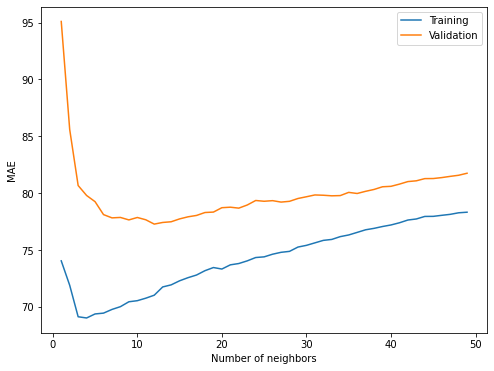

In [26]:
find_knn(x_train, x_test, y_train.values, y_test.values, 50)

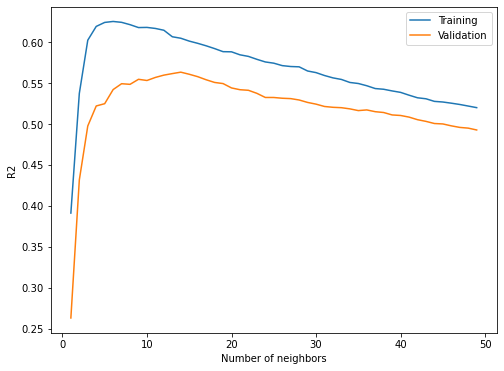

In [27]:
find_knn_R2(x_train, x_test, y_train.values, y_test.values, 50)

Define a function to predict the amount of bikes in the next hour (with optimal k):

In [28]:
def calc_demand(mean_temp, rushhour, season, Weekday, precip):
    features = [[mean_temp, rushhour, season, Weekday, precip]]
    do_knn(features)

def do_knn(features):
    # Fit model
    KNN_reg = KNeighborsRegressor(n_neighbors=12)
    KNN_model = KNN_reg.fit(x_train, y_train.values) 

    # Predict
    y_hat_KNN = KNN_model.predict(x_test)
    
    print("The expected demand in the next hour is: ", KNN_reg.predict(features),
         " with a MAE of: ", mean_absolute_error(y_hat_KNN, y_test), "Bikes, and a ",
            "R2 score of: ", KNN_reg.score(x_test, y_test))
    return KNN_reg.predict(features)

In [29]:
# sample: 22° C, at rushhour, summer, on a weekday, no precip
calc_demand(22, 1, 1, 1, 0)

The expected demand in the next hour is:  [423.5]  with a MAE of:  77.27681248296538 Bikes, and a  R2 score of:  0.5595986806615383


#### Plot Some example predictions

The expected demand in the next hour is:  [5.91666667]  with a MAE of:  77.27681248296538 Bikes, and a  R2 score of:  0.5595986806615383
The expected demand in the next hour is:  [12.5]  with a MAE of:  77.27681248296538 Bikes, and a  R2 score of:  0.5595986806615383
The expected demand in the next hour is:  [347.5]  with a MAE of:  77.27681248296538 Bikes, and a  R2 score of:  0.5595986806615383
The expected demand in the next hour is:  [95.91666667]  with a MAE of:  77.27681248296538 Bikes, and a  R2 score of:  0.5595986806615383
The expected demand in the next hour is:  [326.83333333]  with a MAE of:  77.27681248296538 Bikes, and a  R2 score of:  0.5595986806615383


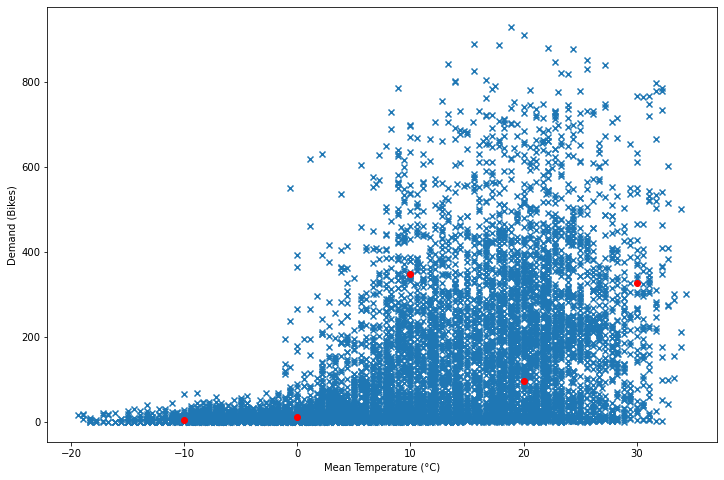

In [30]:
plt.figure(figsize = (12,8))
plt.scatter(X["mean_temp"], y, marker='x', color="C0")

point = do_knn([[-10, 0, 3, 1, 1]])
plt.plot(-10, point[0], marker="o", color='r')

point = do_knn([[0, 0, 2, 0, 0]])
plt.plot(0, point[0], marker="o", color='r')

point = do_knn([[10, 1, 0, 1, 1]])
plt.plot(10, point[0], marker="o", color='r')

point = do_knn([[20, 0, 0, 0, 1]])
plt.plot(20, point[0], marker="o", color='r')

point = do_knn([[30, 1, 1, 1, 0]])
plt.plot(30, point[0], marker="o", color='r')

plt.xlabel("Mean Temperature (°C)")
plt.ylabel("Demand (Bikes)")
plt.show()